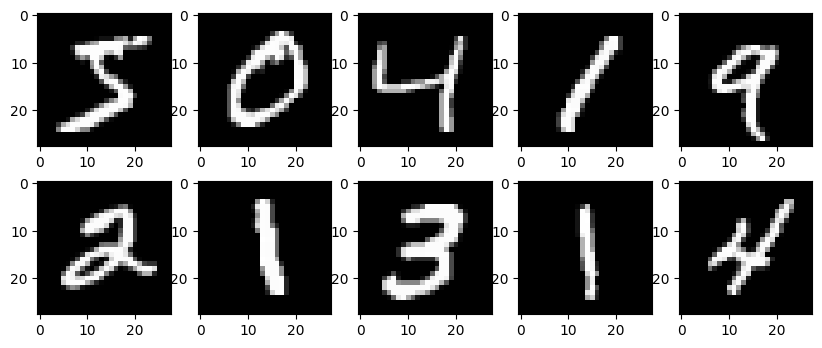

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 对数据集进行了标准化处理。这里的 2个(0.5,)表示每个通道（灰度图像只有一个通道）的均值和标准差，因为 MNIST 数据集是灰度图像，所以只有一个通道。
])

# 加载训练数据集
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 加载测试数据集
testset = datasets.MNIST('data', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# 遛遛部分数据
plt.figure(figsize=(10, 4))
for n in range(10):
    plot = plt.subplot(2,5,n+1)
    plot.imshow(trainset.data[n], cmap='gray')


In [3]:
import torch
import torch.nn as nn

# 定义网络模型类，继承自 nn.Module 类
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积，输入通道数为 1，输出通道数为 10，卷积核大小为 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        # 第二层卷积，输入通道数为 10，输出通道数为 20，卷积核大小为 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # Dropout 层，随机将一些输入置为 0，以防止过拟合
        self.dropout = nn.Dropout2d()
        # 全连接层，输入大小为 320，输出大小为 50
        self.fc1 = nn.Linear(320, 50)
        # 全连接层，输入大小为 50，输出大小为 10
        self.fc2 = nn.Linear(50, 10)

    # 定义前向计算方法
    def forward(self, x):
        # 第一层卷积 + ReLU 激活函数 + 最大池化
        x = nn.functional.relu(nn.functional.max_pool2d(self.conv1(x), 2))
        # 第二层卷积 + ReLU 激活函数 + Dropout 层 + 最大池化
        x = nn.functional.relu(nn.functional.max_pool2d(self.dropout(self.conv2(x)), 2))
        # 将张量形状变为 (batch_size, 320)
        x = x.view(-1, 320)
        # 第一个全连接层 + ReLU 激活函数
        x = nn.functional.relu(self.fc1(x))
        # Dropout 层，随机将一些输入置为 0，以防止过拟合
        x = nn.functional.dropout(x, training=self.training)
        # 第二个全连接层，输出未经 softmax 处理的结果
        x = self.fc2(x)
        # 对输出结果使用 log_softmax 函数进行处理
        return nn.functional.log_softmax(x, dim=1)


# 创建模型实例
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# 定义训练函数，每个 epoch 训练一次
def train(epoch):
    # 将模型设置为训练模式
    model.train()
    # 遍历训练集数据，使用 DataLoader 返回的数据迭代器
    for batch_idx, (data, target) in enumerate(train_loader):
        # 清空梯度
        optimizer.zero_grad()
        # 前向计算，得到输出结果
        output = model(data)
        # 计算损失
        loss = criterion(output, target)
        # 反向传播，计算梯度
        loss.backward()
        # 更新参数
        optimizer.step()
        # 每处理 10 个 batch 输出一次日志
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# 定义测试函数，用于评估模型在测试集上的性能
def test():
    # 将模型设置为评估模式
    model.eval()
    # 初始化测试损失和正确预测的样本数
    test_loss = 0
    correct = 0
    # 使用 with torch.no_grad() 包装测试过程，禁止计算图中的梯度计算
    with torch.no_grad():
        # 遍历测试集数据，使用 DataLoader 返回的数据迭代器
        for data, target in test_loader:
            # 前向计算，得到输出结果
            output = model(data)
            # 计算测试损失
            test_loss += criterion(output, target).item()
            # 找出每个样本预测的类别
            pred = output.data.max(1, keepdim=True)[1]
            # 统计正确预测的样本数
            correct += pred.eq(target.data.view_as(pred)).sum()
    # 计算平均测试损失
    test_loss /= len(test_loader.dataset)
    # 输出测试结果，包括平均损失和准确率
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# 使用 10 个 epoch 进行训练和测试
for epoch in range(1, 3):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302591
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299105
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.275550
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.309930
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.305012
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.291962
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.277216
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.282989
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.301001
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.264502
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.214256
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.275319
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.242531
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.266617
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.217957
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.185662
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.171391
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.160692
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.075197
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.009769
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.398618
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.489552
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.487495
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.369463
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.332242
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.227511
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.335856
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.743167
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.393611
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.524088
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.421272
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.232768
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.315813
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.612053
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.277475
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.450226
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.571307
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.484598
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.266193
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.547367


Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.467615
Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.217758
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.185280
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.226830
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.185772
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.232530
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.317360
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.244656
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.234769
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.187681
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.116678
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.236710
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.170087
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.167561
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.264739
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.233196
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.296566
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.265902
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.325080
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.295574


Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.494132
Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.223934
Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.149916
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.345527
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.327050
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.183283
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.137487
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.190825
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.066286
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.348992
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.379758
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.315865
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.127036
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.365412
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.194175
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.366086
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.277966
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.211512
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.140889
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.376475


Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.253029
Train Epoch: 7 [58240/60000 (97%)]	Loss: 0.217491
Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.114997
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.116912

Test set: Average loss: 0.0011, Accuracy: 9783/10000 (98%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.133074
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.148852
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.105397
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.237776
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.186095
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.255242
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.479394
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.144778
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.288368
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.136094
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.223711
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.046606
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.277770
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.180225
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.243432
Train Epoch: 8 [9

Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.176674
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.123123
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.245229
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.083080
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.124149
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.302017
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.209351
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.218563
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.139928
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.095026
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.174785
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.132184
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.294288
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.090936
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.174450
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.195240
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.092942
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.245558
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.314222
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.312806


torch.Size([10, 1, 28, 28])
torch.Size([10, 10])
tensor(6)


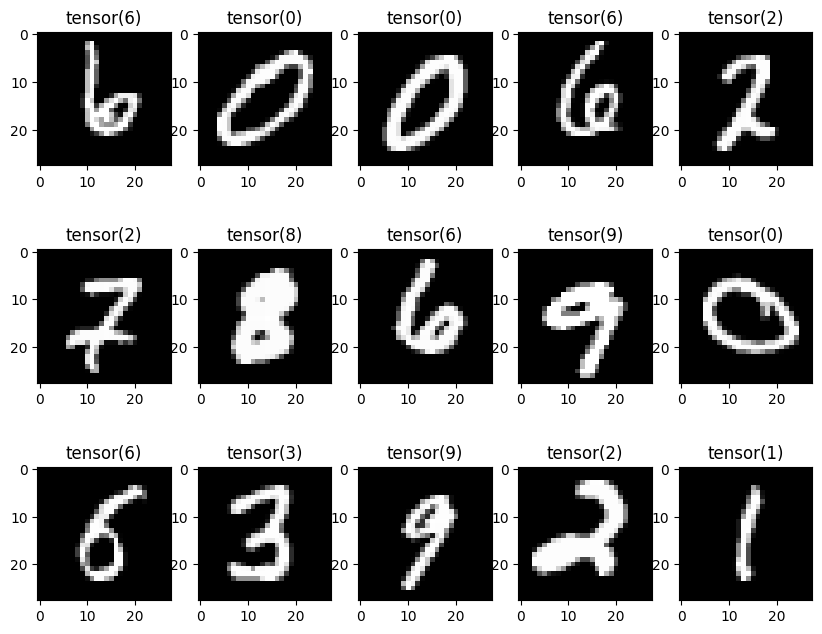

In [4]:
# 训练结束。     
# 把识别结果放到title上，直观的感受一下正确率
for images, labels in test_loader:
    with torch.no_grad():
        output = model(images)
    _, predicted = torch.max(output.data, 1)
    
    print(images[:10,].shape)
    print(output[:10,].shape)
    print(np.argmax(output[0]))
    
    plt.figure(figsize=(10,8))
    for n in range(15):
        plt.subplot(3,5,n+1)
        plt.imshow(images[n].view(28,28), cmap='gray')
        plt.title(np.argmax(output[n]))
    break